In [3]:
!pip install torch torchvision matplotlib
!pip install pytorch-fid torch-fidelity
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [4]:
import os
import torch
import torch.nn as nn
from torchvision.utils import save_image
from torchvision import transforms
from collections import defaultdict
from torch_fidelity import calculate_metrics
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
from torchvision.datasets import ImageFolder


In [ ]:
device = torch.device("cpu")

# Configuration (must match training)
nz = 256
embedding_dim = 256
num_classes = 21
image_size = 128


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.init_proj = nn.Linear(nz + embedding_dim, 2048 * 4 * 4)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, 4, 2, 1), nn.BatchNorm2d(1024), nn.ReLU(True), nn.Dropout(0.35),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  nn.BatchNorm2d(512),  nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),   nn.BatchNorm2d(256),  nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),   nn.BatchNorm2d(128),  nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1),     nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        x = self.init_proj(x).view(-1, 2048, 4, 4)
        return self.model(x)


In [ ]:
G_ema = Generator().to(device)
checkpoint_path = "/content/drive/MyDrive/GAN128_RGB_Tuned/final_generator_ema_ep250.pth"
G_ema.load_state_dict(torch.load(checkpoint_path, map_location=device))
G_ema.eval()

print(" Generator loaded successfully on CPU.")


 Generator loaded successfully on CPU.


In [ ]:
output_root = "/content/drive/MyDrive/GAN_Final_Synthetic_1000"
os.makedirs(output_root, exist_ok=True)

class_labels = sorted(os.listdir("/content/drive/MyDrive/GRAVITY SPY DATASET/train/train"))
if "None_of_the_Above" in class_labels:
    class_labels.remove("None_of_the_Above")

print(f"Classes to generate: {class_labels}")

samples_per_class = 1000

with torch.no_grad():
    for class_idx, class_name in enumerate(class_labels):
        save_path = os.path.join(output_root, class_name)
        os.makedirs(save_path, exist_ok=True)

        for i in range(samples_per_class):
            z = torch.randn(1, nz, device=device)
            label = torch.tensor([class_idx], device=device)
            gen_img = G_ema(z, label)
            save_image(gen_img, os.path.join(save_path, f"{class_name}_gen_{i+1:03}.png"), normalize=True)

        print(f" Generated 1000 images for class: {class_name}")


Classes to generate: ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']
 Generated 1000 images for class: 1080Lines
 Generated 1000 images for class: 1400Ripples
 Generated 1000 images for class: Air_Compressor
 Generated 1000 images for class: Blip
 Generated 1000 images for class: Chirp
 Generated 1000 images for class: Extremely_Loud
 Generated 1000 images for class: Helix
 Generated 1000 images for class: Koi_Fish
 Generated 1000 images for class: Light_Modulation
 Generated 1000 images for class: Low_Frequency_Burst
 Generated 1000 images for class: Low_Frequency_Lines
 Generated 1000 images for class: No_Glitch
 Generated 1000 images for class: Paired_Doves
 Generated 1000 images for class: Power_Line
 Generated 1000 ima

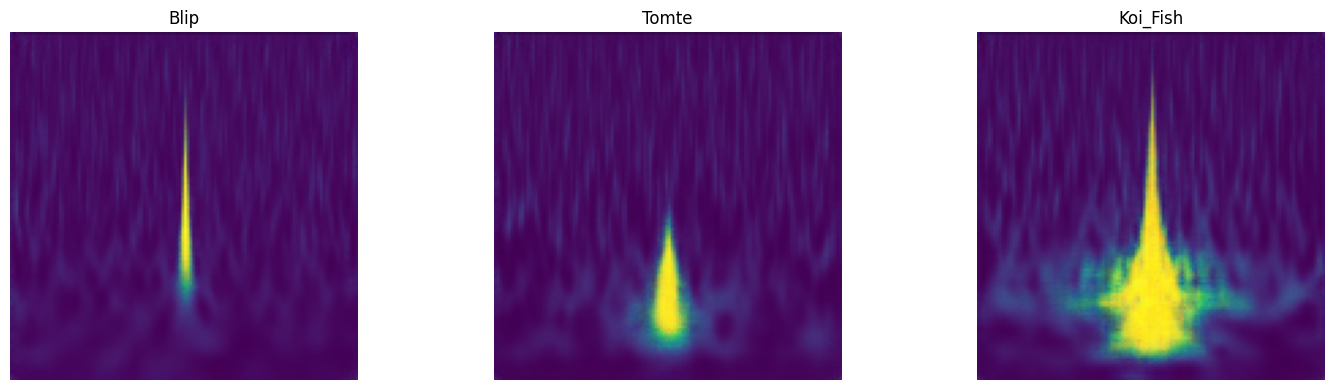

In [6]:
root_dir = "/content/drive/MyDrive/GAN_Final_Synthetic_1000"
selected_classes = ["Blip", "Tomte", "Koi_Fish"]

sample_images = []
labels = []

for cls in selected_classes:
    class_path = os.path.join(root_dir, cls)
    if os.path.isdir(class_path):
        imgs = sorted([f for f in os.listdir(class_path) if f.endswith(".png")])
        if imgs:
            sample_images.append(os.path.join(class_path, imgs[0]))
            labels.append(cls)

cols = 3
rows = 1

plt.figure(figsize=(15, 4))

for idx, (img_path, label) in enumerate(zip(sample_images, labels)):
    img = Image.open(img_path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(label, fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
real_root = "/content/drive/MyDrive/GRAVITY SPY DATASET/train/train"
gan_root = "/content/drive/MyDrive/GAN_Generated_Spectragram_Imgs"
target_root = "/content/drive/MyDrive/Classification_dataset_gravity_spy"
os.makedirs(target_root, exist_ok=True)

# Get class list (excluding None_of_the_Above)
all_classes = sorted([cls for cls in os.listdir(real_root) if cls != "None_of_the_Above"])

N_total = 1000

print(" Merging real + GAN images into Classification_dataset_gravity_spy...\n")

for cls in tqdm(all_classes):
    # Create class folder in target location
    target_dir = os.path.join(target_root, cls)
    os.makedirs(target_dir, exist_ok=True)

    # Get real images
    real_dir = os.path.join(real_root, cls)
    real_imgs = sorted([f for f in os.listdir(real_dir) if f.endswith((".png", ".jpg", ".jpeg"))])

    # Copy real images first
    for i, fname in enumerate(real_imgs[:N_total]):
        src = os.path.join(real_dir, fname)
        dst = os.path.join(target_dir, f"real_{i+1:04}.png")
        shutil.copyfile(src, dst)

    # Fill the rest with GAN images
    needed = N_total - len(real_imgs)
    if needed > 0:
        gan_dir = os.path.join(gan_root, cls)
        gan_imgs = sorted([f for f in os.listdir(gan_dir) if f.startswith("gan_") and f.endswith(".png")])
        for j, fname in enumerate(gan_imgs[:needed]):
            src = os.path.join(gan_dir, fname)
            dst = os.path.join(target_dir, f"gan_{j+1:04}.png")
            shutil.copyfile(src, dst)

    print(f" {cls}: {len(real_imgs[:N_total])} real + {min(needed, len(gan_imgs))} GAN → total: {len(os.listdir(target_dir))} images.")


 Merging real + GAN images into Classification_dataset_gravity_spy...



  5%|▍         | 1/21 [01:35<31:57, 95.86s/it]

 1080Lines: 916 real + 84 GAN → total: 1000 images.


 10%|▉         | 2/21 [02:04<17:49, 56.31s/it]

 1400Ripples: 236 real + 764 GAN → total: 1000 images.


 14%|█▍        | 3/21 [02:36<13:31, 45.08s/it]

 Air_Compressor: 164 real + 836 GAN → total: 1000 images.


 19%|█▉        | 4/21 [05:13<25:16, 89.21s/it]

 Blip: 1000 real + -4096 GAN → total: 1000 images.


 24%|██▍       | 5/21 [05:42<18:03, 67.73s/it]

 Chirp: 164 real + 836 GAN → total: 1000 images.


 29%|██▊       | 6/21 [06:25<14:50, 59.40s/it]

 Extremely_Loud: 1000 real + -264 GAN → total: 1000 images.


 33%|███▎      | 7/21 [06:57<11:42, 50.16s/it]

 Helix: 780 real + 220 GAN → total: 1000 images.


 38%|███▊      | 8/21 [07:49<10:59, 50.75s/it]

 Koi_Fish: 1000 real + -992 GAN → total: 1000 images.


 43%|████▎     | 9/21 [08:25<09:13, 46.12s/it]

 Light_Modulation: 1000 real + -444 GAN → total: 1000 images.


 48%|████▊     | 10/21 [09:09<08:22, 45.71s/it]

 Low_Frequency_Burst: 1000 real + -748 GAN → total: 1000 images.


 52%|█████▏    | 11/21 [09:50<07:21, 44.14s/it]

 Low_Frequency_Lines: 1000 real + -260 GAN → total: 1000 images.


 57%|█████▋    | 12/21 [10:17<05:49, 38.82s/it]

 No_Glitch: 428 real + 572 GAN → total: 1000 images.


 62%|██████▏   | 13/21 [11:25<06:21, 47.66s/it]

 Paired_Doves: 76 real + 924 GAN → total: 1000 images.


 67%|██████▋   | 14/21 [12:14<05:36, 48.12s/it]

 Power_Line: 1000 real + -256 GAN → total: 1000 images.


 71%|███████▏  | 15/21 [12:39<04:07, 41.24s/it]

 Repeating_Blips: 740 real + 260 GAN → total: 1000 images.


 76%|███████▌  | 16/21 [13:23<03:30, 42.16s/it]

 Scattered_Light: 1000 real + -235 GAN → total: 1000 images.


 81%|████████  | 17/21 [14:21<03:06, 46.69s/it]

 Scratchy: 950 real + 50 GAN → total: 1000 images.


 86%|████████▌ | 18/21 [14:43<01:58, 39.45s/it]

 Tomte: 292 real + 708 GAN → total: 1000 images.


 90%|█████████ | 19/21 [15:17<01:15, 37.88s/it]

 Violin_Mode: 1000 real + -137 GAN → total: 1000 images.


 95%|█████████▌| 20/21 [15:44<00:34, 34.60s/it]

 Wandering_Line: 126 real + 874 GAN → total: 1000 images.


100%|██████████| 21/21 [16:12<00:00, 46.31s/it]

 Whistle: 837 real + 163 GAN → total: 1000 images.


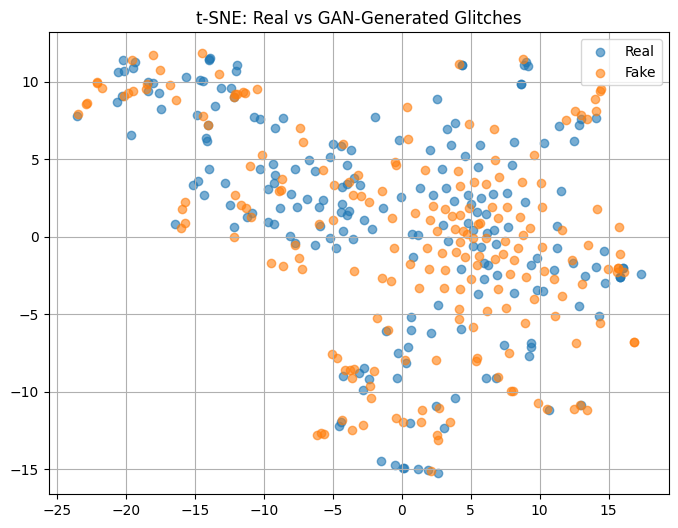

In [7]:
real_path = "/content/drive/MyDrive/GRAVITY SPY DATASET/train/train"
fake_path = "/content/drive/MyDrive/Classification_datset_gravity_spy"

# Use same transform as training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load small batches for visualization
real_dataset = ImageFolder(root=real_path, transform=transform)
fake_dataset = ImageFolder(root=fake_path, transform=transform)

# Reduce size for speed
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=200, shuffle=True)
fake_loader = torch.utils.data.DataLoader(fake_dataset, batch_size=200, shuffle=True)

# Extract one batch from each
real_images, _ = next(iter(real_loader))
fake_images, _ = next(iter(fake_loader))

# Flatten and reduce channel depth
real_flat = real_images.view(real_images.size(0), -1).numpy()
fake_flat = fake_images.view(fake_images.size(0), -1).numpy()

# Combine
X = np.vstack((real_flat, fake_flat))
y = np.array([0]*real_flat.shape[0] + [1]*fake_flat.shape[0])  # 0=real, 1=fake

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], label="Real", alpha=0.6)
plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], label="Fake", alpha=0.6)
plt.title("t-SNE: Real vs GAN-Generated Glitches")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
source_root = "/content/drive/MyDrive/Classification_datset_gravity_spy"
resized_root = "/content/drive/MyDrive/Classification_datset_gravity_spy_resized"

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128)
])

os.makedirs(resized_root, exist_ok=True)

for cls in sorted(os.listdir(source_root)):
    class_path = os.path.join(source_root, cls)
    save_path = os.path.join(resized_root, cls)
    os.makedirs(save_path, exist_ok=True)

    for img_name in tqdm(os.listdir(class_path), desc=f"Resizing {cls}"):
        img_path = os.path.join(class_path, img_name)
        if img_name.endswith((".png", ".jpg", ".jpeg")):
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            img.save(os.path.join(save_path, img_name))


Resizing Whistle: 100%|██████████| 1180/1180 [01:57<00:00, 10.02it/s]


In [9]:
from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1="/content/drive/MyDrive/GRAVITY SPY DATASET/train/train",
    input2="/content/drive/MyDrive/Classification_datset_gravity_spy_resized",
    cuda=False,
    fid=True,
    isc=False,
    kid=False,
    samples_find_deep=True
)

print(f" Torch-Fidelity FID Score: {metrics['frechet_inception_distance']:.2f}")


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 35.6MB/s]
Extracting statistics from input 1
Looking for samples recursively in "/content/drive/MyDrive/GRAVITY SPY DATASET/train/train" with extensions png,jpg,jpeg
Found 22369 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples
Extracting statistics from 

 Torch-Fidelity FID Score: 56.16


Frechet Inception Distance: 56.15981218573165
